In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from brian2 import *
from utils.equations import *
from utils.funcs import *


prefs.codegen.target = "numpy"

# Анализ h-gate при определении максимального тока

In [3]:
def plot_currents(voltages, m_model_neuron, m_model_statemon, restore_name):
    """
    Plots current values for given list of voltages
    
    :param voltages: list of voltages to iterate over
    :param m_model_neuron: NeuronGroup to set voltage for each iteration 
    :param m_model_statemon: StateMonitor to record current values
    """
    for v in voltages:
        restore(restore_name)
        m_model_neuron.v = v
        run(100 * ms)
        plot(m_model_statemon.t / ms, m_model_statemon.INa18[0] / nA)
    xlabel("Time (ms)")
    ylabel("Current (nA)")
    grid()

In [10]:
start_scope()
eq = m3h_s_model + Equations("v : volt (constant)")
group = NeuronGroup(1, eq, method="exponential_euler", namespace=basic_namespace)
mon = StateMonitor(group, ["INa18", "h_s", "m_s"], True)

group.h_s = 0.95
group.m_s = 0.1
group.v = -30 *mV

run(500*ms)

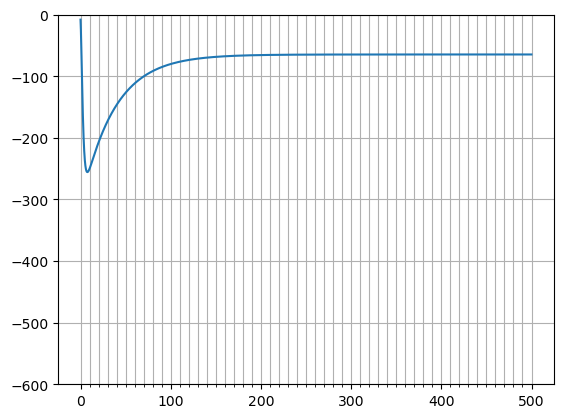

In [5]:
plot(mon.t/ms, mon.INa18[0]/pA)
ylim(-600, 0)
xticks(np.arange(0, 500,10), minor=True, fontsize=5)
grid(True, "both")

# Подбор Nav1.1 для более "физиологических" значений

Сейчас слишком высокая частота. Надо (при не супер-сильном снижении проводимости) сделать поменьше частоту. Либо вообще смотреть на коротком промежутке. \
С другой стороны, может быть можно просто смотреть на низких токах.

Ведь самое главное - поймать переход от ощущения к боли.

- сделать basic model
- добавить nav1.8 (крыловский)
- возможно ещё литературный
- Посмотреть на Ifr curve для перехода от одной модели к другой.

### Базовая модель

In [11]:
# equations lego
basic_I = Equations("""
INa = gNa*m**3*h*(Ena-v) : amp
IK = gK*n**4*(Ek-v) : amp
I : amp
""")


In [41]:
start_scope()
base_master_eq = Equations("dv/dt = (gL*(El-v) + INa + IK + I) / Cm : volt")
base_eq = base_master_eq + basic_I + dmdt + dhdt + dndt
base_group = NeuronGroup(1, base_eq, method="exponential_euler", namespace=basic_namespace)
base_mon = StateMonitor(base_group, ["v"], True)

base_group.v = basic_namespace["El"]
run(10*ms)
base_group.I = 100*pA
run(50*ms)
base_group.I = 0*pA
run(50*ms)

 ### База + $Na_{v1.8}$ из литературы

In [13]:
start_scope()
Lnav_eq = Equations("""
dv/dt = (gL*(El-v) + INa + IK + INa18 + I) / Cm : volt
""")
Lnav_eq = Lnav_eq + basic_I + dmdt + dhdt + dndt + gNa18_eq
Lnav_group = NeuronGroup(1, Lnav_eq, method="exponential_euler", namespace=basic_namespace)
Lnav_mon = StateMonitor(Lnav_group, ["v"], True)

Lnav_group.v = basic_namespace["El"]
run(10*ms)
Lnav_group.I = 100*pA
run(50*ms)
Lnav_group.I = 0*pA
run(50*ms)

### База + $Na_{v1.8}$ Крылова

In [14]:
start_scope()
Knav_eq = Equations("""
dv/dt = (gL*(El-v) + INa + IK + INa18_s + I) / Cm : volt
INa18_s = gNa18*m_s**3*h_s*(Ena-v) : amp
""")
Knav_eq = Knav_eq + basic_I + dmdt + dhdt + dndt + m_s + h_s
Knav_group = NeuronGroup(1, Knav_eq, method="exponential_euler", namespace=basic_namespace)
Knav_mon = StateMonitor(Knav_group, ["v"], True)

Knav_group.v = basic_namespace["El"]
run(10*ms)
Knav_group.I = 100*pA
run(50*ms)
Knav_group.I = 0*pA
run(50*ms)


## Сравнение (база vs. база+Нав)

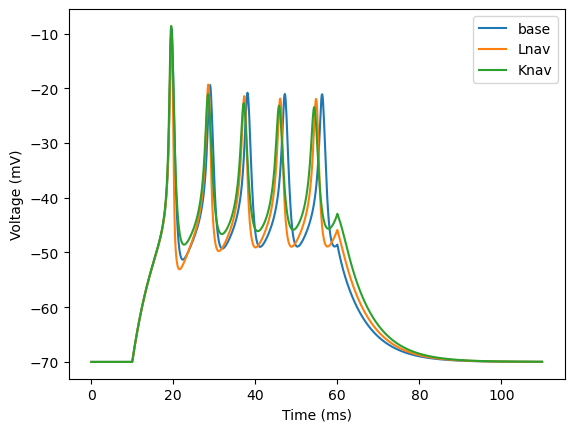

In [15]:
plot(base_mon.t/ms, base_mon.v[0]/mV)
plot(Lnav_mon.t/ms, Lnav_mon.v[0]/mV)
plot(Knav_mon.t/ms, Knav_mon.v[0]/mV)
xlabel("Time (ms)")
ylabel("Voltage (mV)")
legend(["base", "Lnav", "Knav"])

**Выводы по графику**: \
 оба вида nav18 уравнений (из монографии и литературы) увеличивают частоту спайков. Из монографии побольше, что объясняется тем, что просто больше каналов (значение макс. проводимости).

In [16]:
# I-fr curve
Lnav_ifmon, Lnav_ifgroup = compIFcurve_by_equation(Lnav_eq, basic_namespace)
Knav_ifmon, Knav_ifgroup = compIFcurve_by_equation(Knav_eq, basic_namespace)
base_ifmon, base_ifgroup = compIFcurve_by_equation(base_eq, basic_namespace)



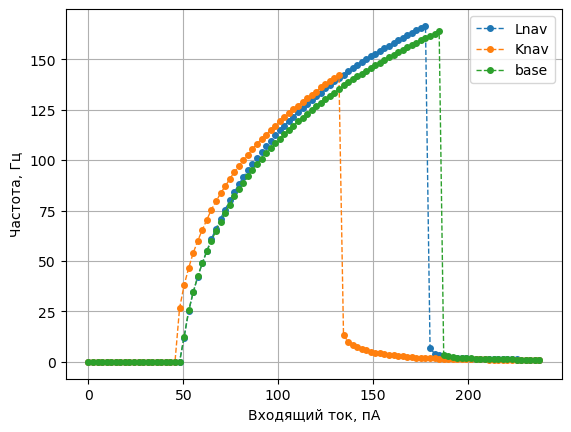

In [17]:
plotIFcurve(Lnav_ifmon, Lnav_ifgroup)
plotIFcurve(Knav_ifmon, Knav_ifgroup)
plotIFcurve(base_ifmon, base_ifgroup)
legend(["Lnav", "Knav", "base"])

**Вывод (текущий)**: \
Да, только нав18 из монографии ведёт себя "похоже". Но, кстати, всё равно не так, как надо. \
Интересное наблюдение. Но теперь нужно подобрать более физиологические параметы для нав1.1. \
- подвигать проводимость (нежелательно)
- подвигать зависимости скоростей активации от вольтажа

## Понизим активность чистого нав1.1 через активацию

Был совет m_inf (или h_inf) подвинуть (влево). Есть с чего начать...

In [219]:
def calculate_m_vars(vv):
    VT = basic_namespace["VT"]/mV
    a_m = 0.32 * 4 / exprel((13 - vv + VT)/4)
    b_m = 0.28 * 5 / exprel((vv - VT - 40)/5)
    m_inf = a_m / (a_m + b_m)
    tau_m = 1 / (a_m + b_m)
    return a_m, b_m, m_inf, tau_m


def calculate_h_vars(vv):
    VT = basic_namespace["VT"]/mV
    a_h = 0.128 * exp((17 - vv + VT)/18)
    b_h = 4 / (1 + exp((40 - vv + VT)/5))
    h_inf = a_h / (a_h + b_h)
    tau_h = 1 / (a_h + b_h)
    return a_h, b_h, h_inf, tau_h


def calculate_new_m_vars(vv):
    """
    a_shift = + 3.5 - немного работает, но просто тяжелее выдавить спайк.
    """
    VT = basic_namespace["VT"]/mV
    a_shift = + 3
    b_shift = + 3
    a_m = 0.32 * 4 * 0.8 / exprel((13 - vv + VT + a_shift)/4)
    b_m = 0.28 * 5 / exprel((vv - VT - 40 + b_shift)/5)
    m_inf = a_m / (a_m + b_m)
    tau_m = 1 / (a_m + b_m)
    return a_m, b_m, m_inf, tau_m


def calculate_new_h_vars(vv):
    VT = basic_namespace["VT"]/mV
    a_shift = 10
    b_shift = 10  # +5 у обоих рейтов работает неплохо (но мало по амплитуде)
    a_h = 0.128*0.2 * exp((17 - vv + VT + a_shift)/18)
    b_h = 4*0.2 / (1 + exp((40 - vv + VT + b_shift)/5))
    h_inf = a_h / (a_h + b_h)
    tau_h = 1 / (a_h + b_h)
    return a_h, b_h, h_inf, tau_h

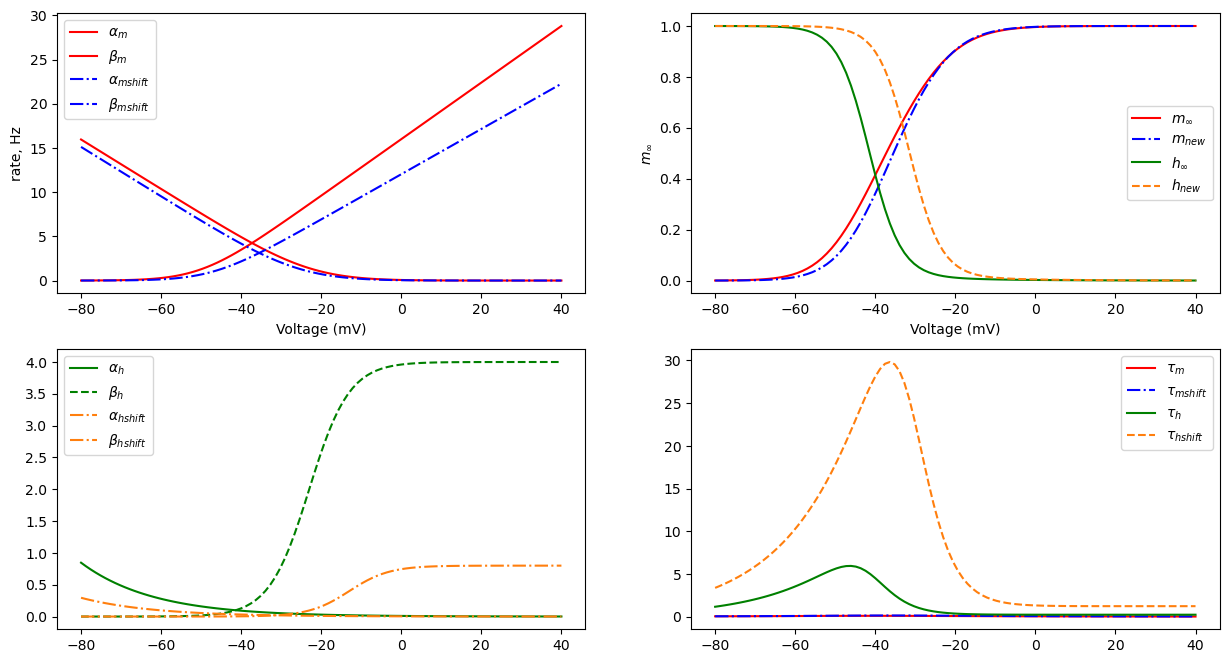

In [220]:
# lets look at m_inf and h_inf
vv = linspace(-80, 40, 100)
a_mm, b_mm, m_inf, tau_m = calculate_m_vars(vv)
a_mm_shift, b_mm_shift, m_inf_shift, tau_mm_shift = calculate_new_m_vars(vv)
a_h, b_h, h_inf, tau_h = calculate_h_vars(vv)
a_h_shift, b_h_shift, h_inf_shift, tau_h_shift = calculate_new_h_vars(vv)

figure(figsize=(15, 8))
subplot(2, 2, 1)
plot(vv, a_mm, "r", label="$\\alpha_m$")
plot(vv, b_mm, "r", label="$\\beta_m$")
plot(vv, a_mm_shift, "b-.", label="$\\alpha_{mshift}$")
plot(vv, b_mm_shift, "b-.", label="$\\beta_{mshift}$")
xlabel("Voltage (mV)")
ylabel("rate, Hz")
legend()
subplot(2, 2, 2)
plot(vv, m_inf, "r", label="$m_{\infty}$")
plot(vv, m_inf_shift, "b-.", label="$m_{new}$")
plot(vv, h_inf, "g", label="$h_{\infty}$")
plot(vv, h_inf_shift, "--", color='tab:orange', label="$h_{new}$")
xlabel("Voltage (mV)")
ylabel("$m_{\infty}$")
legend()
subplot(2, 2, 3)
plot(vv, a_h, "g", label="$\\alpha_h$")
plot(vv, b_h, "g--", label="$\\beta_h$")
plot(vv, a_h_shift, "-.", color="tab:orange", label="$\\alpha_{hshift}$")
plot(vv, b_h_shift, "-.", color="tab:orange", label="$\\beta_{hshift}$")
legend()
subplot(2, 2, 4)
plot(vv, tau_m, "r", label="$\\tau_m$")
plot(vv, tau_mm_shift, "b-.", label="$\\tau_{mshift}$")
plot(vv, tau_h, "g", label="$\\tau_h$")
plot(vv, tau_h_shift, "--", color="tab:orange", label="$\\tau_{hshift}$")
legend()

#### Теперь проверим, как выглядит активность, как выглядит зависимость.

In [231]:
start_scope()
new_dmdt = Equations(
"""
dm/dt = a_m * (1 - m) - b_m * m : 1
a_m = 0.32*4*0.8 / exprel((13*mV - v + VT + 3*mV)/4/mV) / ms : Hz
b_m = 0.28 * 5 / exprel((v - VT - 40*mV + 3*mV)/5/mV) / ms : Hz
"""
)
new_dhdt = Equations(
"""
dh/dt = a_h * (1 - h) - b_h * h : 1
a_h = 0.128*0.2*exp((17*mV - v + VT + 15*mV)/18/mV) / ms : Hz
b_h = 4*0.2 / (1 + exp((40*mV - v + VT + 15*mV)/5/mV)) / ms : Hz
"""
)
new_base_eq = base_master_eq + basic_I + new_dmdt + new_dhdt + dndt
new_base_group = NeuronGroup(1, new_base_eq, method="exponential_euler", namespace=basic_namespace)
new_base_mon = StateMonitor(new_base_group, ["v"], True)

new_base_group.v = basic_namespace["El"]
run(10*ms)
new_base_group.I = 100*pA
run(50*ms)
new_base_group.I = 0*pA
run(50*ms)

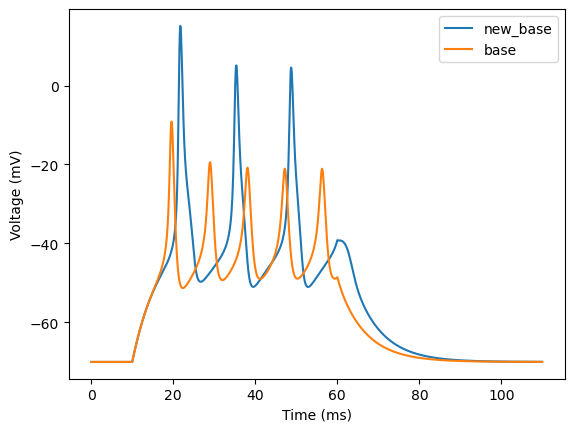

In [228]:
plot(new_base_mon.t/ms, new_base_mon.v[0]/mV, label="new_base")
plot(base_mon.t/ms, base_mon.v[0]/mV, label="base")
xlabel("Time (ms)")
ylabel("Voltage (mV)")
legend()

In [229]:
# if by equation
new_base_ifmon, new_base_ifgroup = compIFcurve_by_equation(new_base_eq, basic_namespace)

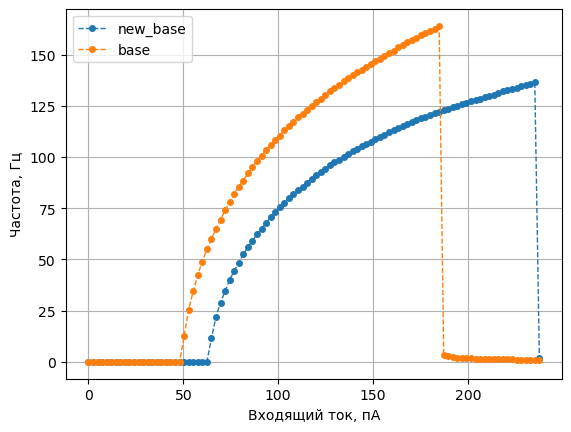

In [230]:
plotIFcurve(new_base_ifmon, new_base_ifgroup)
plotIFcurve(base_ifmon, base_ifgroup)
legend(["new_base", "base"])